In [1]:
# import packages for uploading data
import pandas as pd
# import RFINN
from RFINN import *

# import k-fold function
from sklearn.model_selection import KFold

# import regex for sample_parser
import re

In [2]:
# user must define a function called sample_parser, 
# sample_parser takes sample ids with replicate info at returns just the sample number
# eg. 100A --> 100 
def sample_parser(sample_id):
    return re.split("[ABCDEF]", sample_id)[0]

# user defines number of k-fold splits (more k-folds means more training data, but longer run times)
n_splits = 15

# Preprocessing 

1. Roll up OTUs to Genus level 
2. Truncate Genera to set of shared genera among Pine, Oak, and Grass data sets 
3. Run RFINN feature selection (with kfold?) 

In [3]:
def roll_OTUs(taxonomy, data_otu, level):
    # create a hashtable with keys: genera, items: otus in genus specified by key
    genera = taxonomy[level].values
    otus   = taxonomy['OTUID'].values

    unique_genera = np.unique(genera)
    genera_otu_dict = {}
    for genus in unique_genera:
        # get all the otus in genus
        genus_inds = np.in1d(genera, genus)
        genus_otus = otus[genus_inds]
        # populate hashtable with the set of otus for particular genus 
        genera_otu_dict[genus] = genus_otus

    # create a matrix with columns = genera, rows = samples, 
    # [element]ij = AVG otu abundance for jth genera in ith sample 
    n_samples = data_otu.values.shape[0]

    # determine otus in the otu table (otu table may not have all the otus in the taxonomy table)
    otu_table_otus = data_otu.columns.values[1:]

    # instantiate lists of vectors of genera and genera names  
    A = []
    A_genera_names = []

    for j, genus in enumerate(unique_genera):
        # average over all otus in genus 
        otus = genera_otu_dict[genus]
        # count the number of times an OTU is added 
        k = 0
        genus_counts = np.zeros(n_samples)
        for otu in otus:
            if otu in otu_table_otus:
                genus_counts += data_otu[otu].values 
                k += 1
        # take average 
        if k>0:
            # append a column vector 
            A.append(np.atleast_2d(genus_counts/k).T)
            # append genus name 
            A_genera_names.append(genus)
    # concatenate list into matrix 
    A = np.concatenate(A, axis=1)

    # create a dataframe 
    data_genera = pd.DataFrame(data=A, columns=A_genera_names)
    
    # insert sample id 
    data_genera.insert(0, "Sample ID", data_otu.iloc[:, 0])
    
    return data_genera

# Run RFINN over K-fold partitions of data

In [4]:
# function to create a dictionary mapping sample to a set of replicates
def get_sample_dict(data_df, sample_parser):
    # get the set of samples
    sample_ids = data_df.iloc[:, 0].values
    sample_ids_norep = [sample_parser(s) for s in sample_ids]
    # determine unique set of samples
    unique_samples = np.unique(sample_ids_norep)
    # create sample_dict to map sample id without rep to set of replicate samples 
    sample_dict = {}
    for s in unique_samples:
        # get all replicates of sample s
        sample_inds = np.in1d(sample_ids_norep, s)
        replicates = data_df.iloc[sample_inds, :]
        # store replicates in dict 
        sample_dict[s] = replicates
    # create a dataframe that has the sample names
    sample_df = pd.DataFrame()
    sample_df["Samples"] = unique_samples
    
    return sample_dict, sample_df

# function to return dataframes 
def get_Xtrain_Xtest(sample_dict, train_samples, test_samples):
    
    # create train dataframe
    for i, train_sample in enumerate(train_samples):
        # pull the dataframe for the sample
        if i==0:
            Xtrain_df = sample_dict[train_sample]
        else:
            Xtrain_df = pd.concat((Xtrain_df, sample_dict[train_sample]))
    
    # create test dataframe 
    for i, test_sample in enumerate(test_samples):
        # pull the dataframe for the sample
        if i==0:
            Xtest_df = sample_dict[test_sample]
        else:
            Xtest_df = pd.concat((Xtest_df, sample_dict[test_sample]))
    
    return Xtrain_df, Xtest_df 

In [17]:
# import taxonomy info 
taxonomy = pd.read_csv("data/mktaxfun.csv")

# import data 
microbe_type = 'fun'
litter_types  = ['pine', 'oak', 'grass']

# create a set of dataframes
data_frames = []
features = []

# upload otu tables for each litter type and convert to genera tables 
for litter_type in litter_types:
    data_otu = pd.read_csv("data/OTU_tables/rare1000_otu_{}_{}.csv".format(microbe_type, litter_type))
    data_genera = roll_OTUs(taxonomy, data_otu, level="Genus")
    data_frames.append(data_genera)
    features.append(data_genera.columns.values[1:]) 
    
# truncate features to only include the shared set of genera across all data sets 
all_features = []
for litter_features in features:
    all_features += list(litter_features)
unique_features,counts = np.unique(np.array(all_features), return_counts=True)
kept_features = unique_features[counts==len(litter_types)]
    
for i, litter_type in enumerate(litter_types):   
    
    targets = pd.read_csv("data/Targets_Tables/DOC_{}_{}.csv".format(microbe_type, litter_type))
    
    # only keep shared features 
    data_df = data_frames[i]
    data_samples = data_df.iloc[:, 0].values 
    data_df = data_df[kept_features]
    data_df.insert(0, "Sample ID", data_samples)
    
    # store out of fold predictions 
    oof_RF = []
    oof_NN = []
    Y_true = []

    # K-fold partitions of the data
    
    # create a dictionary mapping sample to a set of replicates
    # k-folds will divide samples, keeping replicates contained within train and test folds
    sample_dict, sample_df = get_sample_dict(data_df, sample_parser)
    kf = KFold(n_splits=n_splits, shuffle=True)
    kf.get_n_splits(sample_df)
    for j,(train_index, test_index) in enumerate(kf.split(sample_df)):
        
        print("Litter: {}, Fold: {}".format(litter_type, j+1))
        
        train_samples = sample_df.iloc[train_index].values.flatten()
        test_samples  = sample_df.iloc[test_index].values.flatten()
        Xtrain_df, Xtest_df = get_Xtrain_Xtest(sample_dict, train_samples, test_samples) 
        
        # run feature selection
        FS = FeatureSelection(Xtrain_df, Xtest_df, targets, rep_seqs=None)
        if j==0:
            FS_results = FS.FeatureSelectionTable(iterations=100)
            FS_results["K"] = [j]*FS_results.shape[0]
        else:
            FS_results_tmp = FS.FeatureSelectionTable(iterations=100)
            FS_results_tmp["K"] = [j]*FS_results_tmp.shape[0]
            FS_results = pd.concat((FS_results, FS_results_tmp))
            
        # make predictions on held out data using RF and NN     
        
        # instantiate model class
        model = Model('Random Forest', Xtrain_df, Xtest_df, targets)
        model.tune_hyper_params()

        # train model
        model.train_model()

        # test model
        Y_test, Y_pred_test, R = model.test_model(plot=False)
        oof_RF.append(Y_pred_test) 
        
        # instantiate model class
        model = Model('Neural Network', Xtrain_df, Xtest_df, targets)
        model.tune_hyper_params()

        # train model
        model.train_model()

        # test model
        Y_test, Y_pred_test, R = model.test_model(plot=False)
        oof_NN.append(Y_pred_test) 
        
        # keep track of true values
        Y_true.append(Y_test)
    
    # save feature selection results
    FS_results.to_csv("results/DOC_genera_{}_{}.csv".format(microbe_type, litter_type), index=False)
    
    # save prediction results 
    prediction_df = pd.DataFrame()
    prediction_df['Y true'] = np.concatenate(Y_true)
    prediction_df['NN predictions'] = np.concatenate(oof_NN)
    prediction_df['RF predictions'] = np.concatenate(oof_RF)
    prediction_df.to_csv("results/DOC_predictions_{}_{}.csv".format(microbe_type, litter_type), index=False)

Litter: pine, Fold: 1
Litter: pine, Fold: 2
Litter: pine, Fold: 3
Litter: pine, Fold: 4
Litter: pine, Fold: 5
Litter: pine, Fold: 6
Litter: pine, Fold: 7
Litter: pine, Fold: 8
Litter: pine, Fold: 9
Litter: pine, Fold: 10
Litter: pine, Fold: 11
Litter: pine, Fold: 12
Litter: pine, Fold: 13
Litter: pine, Fold: 14
Litter: pine, Fold: 15
Litter: oak, Fold: 1
Litter: oak, Fold: 2
Litter: oak, Fold: 3
Litter: oak, Fold: 4
Litter: oak, Fold: 5
Litter: oak, Fold: 6
Litter: oak, Fold: 7
Litter: oak, Fold: 8
Litter: oak, Fold: 9
Litter: oak, Fold: 10
Litter: oak, Fold: 11
Litter: oak, Fold: 12
Litter: oak, Fold: 13
Litter: oak, Fold: 14
Litter: oak, Fold: 15
Litter: grass, Fold: 1
Litter: grass, Fold: 2
Litter: grass, Fold: 3
Litter: grass, Fold: 4
Litter: grass, Fold: 5
Litter: grass, Fold: 6
Litter: grass, Fold: 7
Litter: grass, Fold: 8
Litter: grass, Fold: 9
Litter: grass, Fold: 10
Litter: grass, Fold: 11
Litter: grass, Fold: 12
Litter: grass, Fold: 13
Litter: grass, Fold: 14
Litter: grass, F

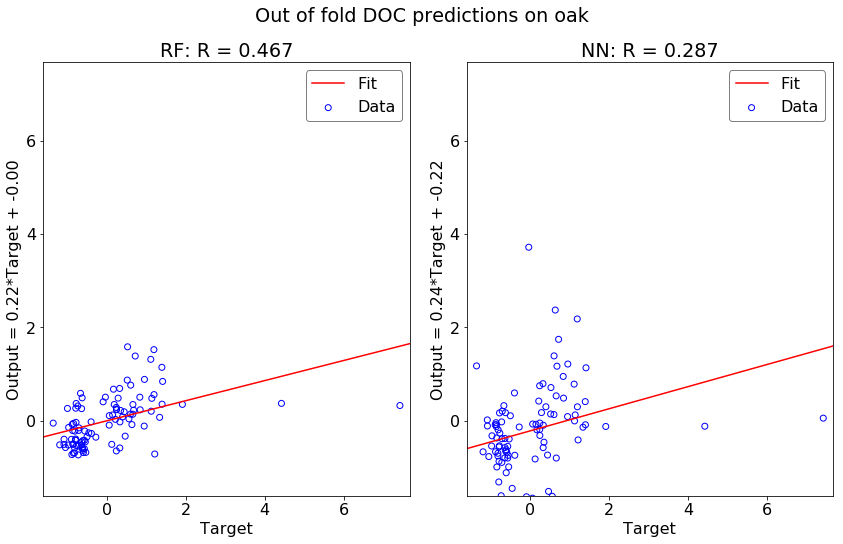

In [21]:
microbe_type = 'fun'
litter_type  = 'oak'

prediction_df = pd.read_csv("results/DOC_predictions_{}_{}.csv".format(microbe_type, litter_type))
Y_true = prediction_df['Y true'].values
Y_pred_RF = prediction_df['RF predictions'].values
Y_pred_NN = prediction_df['NN predictions'].values

plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
plt.scatter(Y_true, Y_pred_RF, facecolors='none', edgecolors='b', label='Data')
#xlim = plt.xlim()
#ylim = plt.ylim()
pad = .25
xlim = [min(Y_true)-pad, max(Y_true)+pad]
ylim = [min(Y_true)-pad, max(Y_true)+pad]
slope, intercept, r_value, p_value, std_err = stats.linregress(Y_true, Y_pred_RF)
x = np.linspace(min(xlim), max(xlim), 100)
line = np.multiply(slope,x) + np.array(intercept)
plt.plot(x, line, 'r', label='Fit')
title_string = 'RF: R = %.3f' % r_value
ylabel = 'Output = {0:.2f}*Target + {1:.2f}'.format(slope, intercept)
plt.title(title_string)
plt.xlabel('Target')
plt.ylabel(ylabel)
plt.xlim(xlim)
plt.ylim(ylim)
#plt.ylim([ymin-pad, ymax+pad])
plt.legend()

# plot test data results
plt.subplot(1,2,2)
plt.scatter(Y_true, Y_pred_NN, facecolors='none', edgecolors='b', label='Data')
#xlim = plt.xlim()
#ylim = plt.ylim()
pad = .25
xlim = [min(Y_true)-pad, max(Y_true)+pad]
ylim = [min(Y_true)-pad, max(Y_true)+pad]
slope, intercept, r_value, p_value, std_err = stats.linregress(Y_true, Y_pred_NN)
x = np.linspace(min(xlim), max(xlim), 100)
line = np.multiply(slope,x) + np.array(intercept)
plt.plot(x, line, 'r', label='Fit')
title_string = 'NN: R = %.3f' % r_value
ylabel = 'Output = {0:.2f}*Target + {1:.2f}'.format(slope, intercept)
plt.title(title_string)
plt.xlabel('Target')
plt.ylabel(ylabel)
plt.xlim(xlim)
plt.ylim(ylim)
#plt.ylim([ymin-pad, ymax+pad])
plt.legend()

# save or show figures
plt.suptitle("Out of fold DOC predictions on {}".format(litter_type))
plt.tight_layout(rect=[0, .03, 1, .95])
plt.savefig("results/DOC_predictions_{}_{}".format(microbe_type, litter_type))
plt.show()

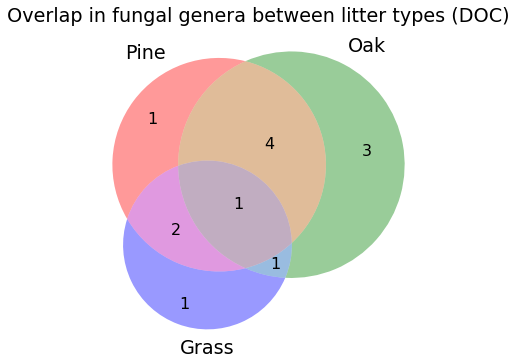

In [7]:
# import plotting libraries
import matplotlib.pyplot as plt
import matplotlib_venn
from matplotlib_venn import venn2, venn3

#%% look at otu overlap btw litter types

pine  = np.unique(pd.read_csv("results/DOC_genera_{}_pine.csv".format(microbe_type))['Taxa'].values)
oak   = np.unique(pd.read_csv("results/DOC_genera_{}_oak.csv".format(microbe_type))['Taxa'].values)
grass = np.unique(pd.read_csv("results/DOC_genera_{}_grass.csv".format(microbe_type))['Taxa'].values)

#%% use FS_results to create FS venn diagram and FS plot figures
plt.style.use('seaborn-colorblind')
plt.rcParams.update({'font.size': 16,
                     'legend.framealpha':.5,
                     'legend.edgecolor':'k',
                     'axes.edgecolor':'k'})
plt.figure(figsize=(9, 6))

venn3([set(pine), set(oak), set(grass)],
    ('Pine', 'Oak', 'Grass'))

plt.title("Overlap in fungal genera between litter types (DOC)")
plt.savefig("results/venn/DOC_Venn_{}.png".format(microbe_type), dpi=150)
plt.show()

In [16]:
# make another table to complement the venn diagram 
venn_table = pd.DataFrame()
n_elements = np.max([len(pine), len(oak), len(grass)])
venn_table["Pine genera"]  = list(pine)  + [""]*(n_elements-len(pine)) 
venn_table["Oak genera"]   = list(oak)   + [""]*(n_elements-len(oak))
venn_table["Grass genera"] = list(grass) + [""]*(n_elements-len(grass))

pine_and_oak,c = np.unique(list(pine)+list(oak), return_counts=True)
pine_and_oak = pine_and_oak[c==2]
venn_table["Pine, oak genera"] = list(pine_and_oak) + [""]*(n_elements-len(pine_and_oak))

pine_and_grass,c = np.unique(list(pine)+list(grass), return_counts=True)
pine_and_grass = pine_and_grass[c==2]
venn_table["Pine, grass genera"] = list(pine_and_grass) + [""]*(n_elements-len(pine_and_grass))

oak_and_grass,c = np.unique(list(grass)+list(oak), return_counts=True)
oak_and_grass = oak_and_grass[c==2]
venn_table["Oak, grass genera"] = list(oak_and_grass) + [""]*(n_elements-len(oak_and_grass))

all_litter, c = np.unique(list(grass)+list(oak)+list(pine), return_counts=True)
all_litter = all_litter[c==3]
venn_table["Pine, oak, grass genera"] = list(all_litter) + [""]*(n_elements-len(all_litter))

venn_table.to_csv("results/venn/DOC_Venn_table_{}.csv".format(microbe_type), index=False)
venn_table

,Pine genera,Oak genera,Grass genera,"Pine, oak genera","Pine, grass genera","Oak, grass genera","Pine, oak, grass genera"
0,Alternaria,Aspergillus,Chaetomidium,Aspergillus,Crinula,Doratomyces,Plectosphaerella
1,Aspergillus,Bionectria,Crinula,Chaetosphaeronema,Plectosphaerella,Plectosphaerella,
2,Chaetosphaeronema,Chaetosphaeronema,Doratomyces,Emericella,Preussia,,
3,Crinula,Doratomyces,Plectosphaerella,Gibberella,,,
4,Emericella,Emericella,Preussia,Plectosphaerella,,,
5,Gibberella,Gibberella,,,,,
6,Plectosphaerella,Massarina,,,,,
7,Preussia,Penicillium,,,,,
8,,Plectosphaerella,,,,,
